# Artificial Intelligence (AI) Project by Nijat Abdullazada and Kamal Alasgarli
## Nijat Abdullazada N22022715
## Kamal Alasgarli N22022741

### Importing necessary libraries

In [26]:
import random
import numpy as np
import pandas as pd
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt

### Loading and preprocessing the data

In [27]:
# Load the data
white_wine_ds = pd.read_csv("data/winequality-white_NO_ALCOHOL.csv", sep=";")
red_wine_ds = pd.read_csv("data/winequality-red_NO_ALCOHOL.csv", sep=";")


# Add the type column
white_wine_ds["type"] = 1
red_wine_ds["type"] = 0

# Concatenate the two datasets
wine_ds = pd.concat([white_wine_ds, red_wine_ds])

# Move the type column to the first position
last_column = wine_ds.columns[-1]
wine_ds = pd.concat([wine_ds[last_column], wine_ds.drop(last_column, axis=1)], axis=1)

# Rename the columns
column_names = []
for column in wine_ds.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
wine_ds.columns = column_names

wine_ds.head()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,6


In [28]:
# Shape of the dataset
print("Shape of the dataset: ", wine_ds.shape)

Shape of the dataset:  (6497, 12)


In [29]:
# Characteristics of the dataset
wine_ds.describe()

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,0.753886,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,5.818378
std,0.430779,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,0.873255
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,3.000000
25%,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,5.000000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,6.000000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,9.000000


### Finding relation strength by plotting the correlation matrix of features into a heatmap

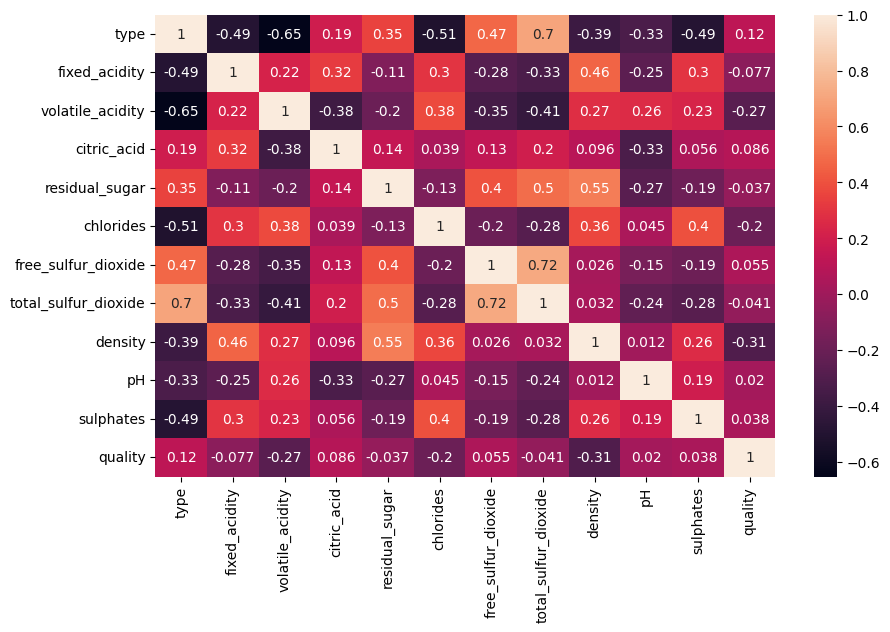

In [30]:
# find correlation matrix in data and plot heatmap
correlation_matrix = wine_ds.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### Splitting the dataset into train and test sets

In [31]:
train_ds = wine_ds.sample(frac=0.8, random_state=0)
test_ds = wine_ds.drop(train_ds.index)

### Determining if a column is continous or categorical
Boolean datatypes are categorical while number is continous

In [32]:
#create categorical continous enum
class FeatureType(Enum):
    CONTINUOUS = 1
    CATEGORICAL = 2

# Determine the feature type, continuous or categorical
def determine_feature_type(df):
    
    feature_types = []
    for feature in df.columns:
        if feature != "quality":
            unique_values = df[feature].unique()
            value = unique_values[0]

            if (isinstance(value, str)) or (len(unique_values) <= 15):
                feature_types.append(FeatureType.CATEGORICAL)
            else:
                feature_types.append(FeatureType.CONTINUOUS)
    
    return feature_types

### Decision Tree class using Gini index from scratch

In [33]:
class DecisionTree:
    def __init__(self):
        self.column_headers = None
        self.feature_types = None

    # Check if the data is pure
    def check_purity(self, data):        
        return len(np.unique(data[:, -1])) == 1

    # Classify the data
    def classify_data(self, data):
        unique_classes, class_counts = np.unique(data[:, -1], return_counts=True)
        index = class_counts.argmax()
        return unique_classes[index]

    # Get potential splits for the given data to create the decision tree
    def get_splits(self, data, n_features):

        splits = {}
        n_rows, n_columns = data.shape
        indices = list(range(n_columns - 1))

        if n_features and n_features <= len(indices):
            indices = random.sample(indices, k=n_features)

        for index in indices:
            splits[index] = np.unique(data[:, index])

        return splits

    # Calculate the gini index
    def gini(self, data):

        _, counts = np.unique(data[:, -1], return_counts=True)

        # Calculate the probabilities
        probabilities = counts / counts.sum()
        return 1 - sum(probabilities**2)

    # Calculate the overall gini index for a split
    def overall_gini(self, data_below, data_above):

        sum = len(data_below) + len(data_above)
        p_data_below = len(data_below) / sum
        p_data_above = len(data_above) / sum
        return p_data_below * self.gini(data_below) + p_data_above * self.gini(data_above)

    # Determine the best split for the decision tree by choosing the split with the lowest gini index
    def determine_best_split(self, data, splits):

        best_gini = 9999

        for index in splits:
            for value in splits[index]:

                data_below, data_above = self.split_data(data, index, value)
                current_gini = self.overall_gini(data_below, data_above)

                if current_gini <= best_gini:
                    best_gini = current_gini
                    best_split_column = index
                    best_split_value = value

        return best_split_column, best_split_value

    # Split the data into two parts, below and above the threshold value
    def split_data(self, data, split_column, split_value):
        column_values = data[:, split_column]
        feature_type = self.feature_types[split_column]

        match (feature_type):
            case FeatureType.CONTINUOUS:
                data_below = data[column_values <= split_value]
                data_above = data[column_values > split_value]
            case FeatureType.CATEGORICAL:
                data_below = data[column_values == split_value]
                data_above = data[column_values != split_value]

        return data_below, data_above

    # Create the decision tree
    def decision_tree_algorithm(self, df, counter=0, min_samples=2, max_depth=5, n_features=None):
        if counter == 0:
            self.column_headers = df.columns
            self.feature_types = determine_feature_type(df)
            data = df.values
        else:
            data = df

        if (self.check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
            return self.classify_data(data)
        else:

            counter += 1

            splits = self.get_splits(data, n_features)
            split_column, split_value = self.determine_best_split(data, splits)
            data_below, data_above = self.split_data(data, split_column, split_value)

            if len(data_below) == 0 or len(data_above) == 0:
                return self.classify_data(data)

            feature_name = self.column_headers[split_column]
            feature_type = self.feature_types[split_column]

            match (feature_type):
                case FeatureType.CONTINUOUS:
                    node = "{} <= {}".format(feature_name, split_value)
                case FeatureType.CATEGORICAL:
                    node = "{} = {}".format(feature_name, split_value)

            sub_tree = {node: []}

            yes_answer = self.decision_tree_algorithm(data_below, counter, min_samples, max_depth, n_features)
            no_answer = self.decision_tree_algorithm(data_above, counter, min_samples, max_depth, n_features)

            if yes_answer == no_answer:
                sub_tree = yes_answer
            else:
                sub_tree[node].append(yes_answer)
                sub_tree[node].append(no_answer)

            return sub_tree

    # Predict
    def predict_example(self, example, tree):

        node = list(tree.keys())[0]
        feature_name, comparison_operator, value = node.split(" ")

        if comparison_operator == "<=":
            if example[feature_name] <= float(value):
                answer = tree[node][0]
            else:
                answer = tree[node][1]
        else:
            if str(example[feature_name]) == value:
                answer = tree[node][0]
            else:
                answer = tree[node][1]

        if not isinstance(answer, dict):
            return answer
        else:
            subtree = answer
            return self.predict_example(example, subtree)

    # Predictions applied to the dataset
    def decision_tree_predictions(self, test_df, tree):
        predictions = test_df.apply(self.predict_example, args=(tree,), axis=1)
        return predictions


### Implementation of Random Forest from scratch using bootstrapping technique

In [34]:
class RandomForest:
    def __init__(self, n_trees=10, min_samples=2, max_depth=5, n_features=None):
        self.n_trees = n_trees
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.n_features = n_features
        self.decision_trees = []

    # Select random samples from the dataset
    def bootstrapping(self, df, n):
        return df.sample(n=n, replace=True)

    # Fit the random forest model
    def fit(self, df):
        self.decision_trees = []
        for i in range(self.n_trees):
            df_bootstrapped = self.bootstrapping(df, n=len(df))
            decision_tree = DecisionTree()
            tree = decision_tree.decision_tree_algorithm(df_bootstrapped, min_samples=self.min_samples, max_depth=self.max_depth, n_features=self.n_features)
            self.decision_trees.append(tree)

    # Predict
    def predict(self, test_df):
        df_predictions = {}
        for i in range(len(self.decision_trees)):
            column_name = "tree_{}".format(i)
            predictions = DecisionTree().decision_tree_predictions(test_df, self.decision_trees[i])
            df_predictions[column_name] = predictions

        df_predictions = pd.DataFrame(df_predictions)
        random_forest_predictions = df_predictions.mode(axis=1)[0]
        return random_forest_predictions

    # Calculate the accuracy of the model
    def accuracy(self, y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

    # Evaluate the model
    def evaluate(self, test_df, y_true):
        return self.accuracy(y_true, self.predict(test_df))
    
    # Feature importance
    def feature_importance(self, df):
        feature_importance = {}
        for i in range(len(self.decision_trees)):
            tree = self.decision_trees[i]
            for question in tree.keys():
                feature_name = question.split()[0]
                if feature_name not in feature_importance:
                    feature_importance[feature_name] = 0
                feature_importance[feature_name] += 1

        feature_importance = pd.DataFrame(feature_importance.values(), index=feature_importance.keys(), columns=["importance"])
        feature_importance = feature_importance / len(self.decision_trees)
        feature_importance = feature_importance.sort_values(by="importance", ascending=False)
        return feature_importance
    


In [35]:
random_forest = RandomForest(n_trees=10, max_depth=5, n_features=10)
random_forest.fit(train_ds)

### Plotting the importance of features

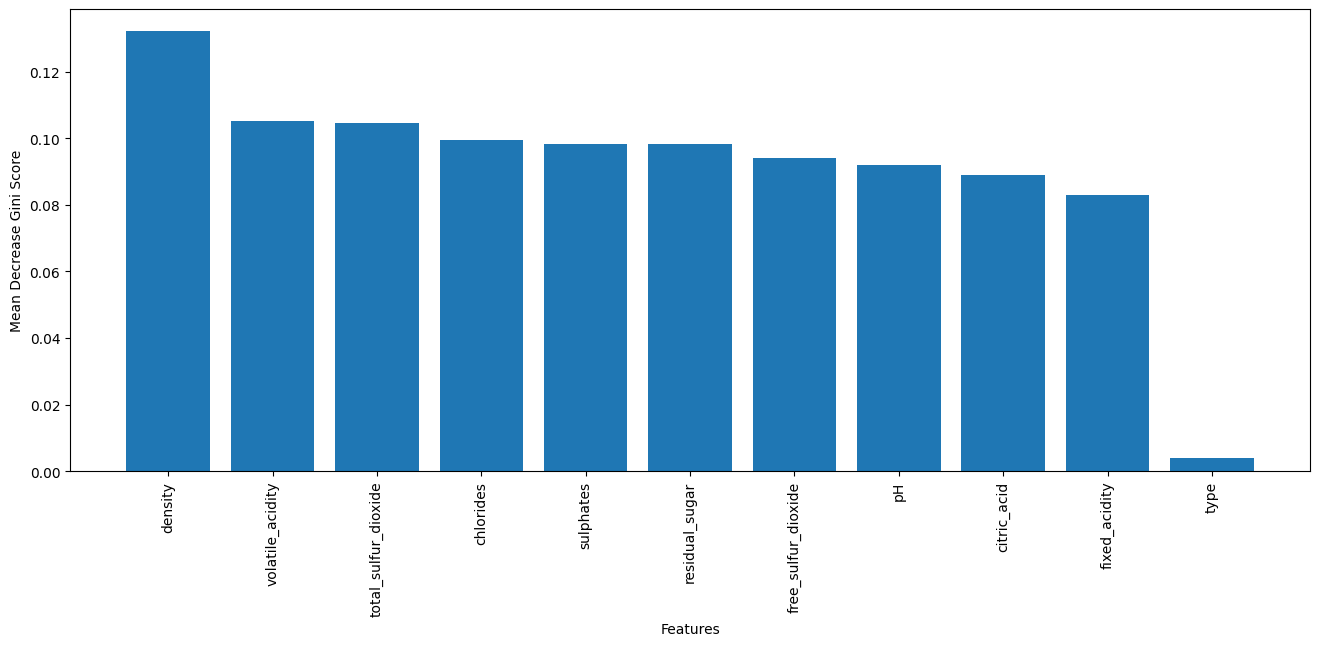

In [ ]:
# Plot importance of predictors using mean decrease in impurity
feature_importance = random_forest.feature_importance(train_ds)
plt.figure(figsize=(16, 6))
feature_importance.plot(kind="bar")
plt.show()


### Accuracy without feature engineering

In [36]:
accuracy = random_forest.evaluate(test_ds, test_ds.quality)
print("Accuracy:", accuracy)

Accuracy: 0.5524652338811631


### Accuracy with feature engineering

In [37]:
def transform_label(value):
    if value > 5:
        return 1
    else:
        return 0


wine_ds["quality"] = wine_ds.quality.apply(transform_label)

In [38]:
train_ds = wine_ds.sample(frac=0.8, random_state=0)
test_ds = wine_ds.drop(train_ds.index)

In [41]:
random_forest = RandomForest(n_trees=10, max_depth=5, n_features=5)
random_forest.fit(train_ds)

In [43]:
accuracy = random_forest.evaluate(test_ds, test_ds.quality)
print("Accuracy:", accuracy)

Accuracy: 0.7243994943109987
